In [ ]:
# This Notebook was authored by Naman Bansal
# https://github.com/nb4159
# https://www.kaggle.com/namanbansal4122
# https://www.linkedin.com/in/naman-bansal-aa723024b/

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

# What is Image Segmentation ?
- In digital image processing and computer vision, image segmentation is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects (sets of pixels). 
- The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
- Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.
- Types of Segmentation:-
    1. __Semantic segmentation__ associates every pixel of an image with a class label such as a person, flower, car and so on. It treats multiple objects of the same class as a single entity.
    2. __Instance segmentation__ treats multiple objects of the same class as distinct individual instances.
- We will deal with Semantic Segmentation in this notebook

__Source:__ https://en.wikipedia.org/wiki/Image_segmentation

<img src="https://i.stack.imgur.com/MEB9F.png">

In [2]:
base_directory = '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [3]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


# Segmentation of Forests in Satellite Images
- We will segment the forest areas in the satellite images
- Since we are going to segment multiple instances of forests present in an image and are not interested in identifying separate instances individually we will perform semantic segmentation
- Forest segmentation finds its application in Land use/Land cover. e.g Forest cover is the amount of land area that is covered by forest. It may be measured as relative or absolute. We can do this by identifying the forest regions and develop a functionality to measure the forest cover from the satellite images itself

<img src='https://d3i71xaburhd42.cloudfront.net/6269c25f3cebe4dba83bd7feb78735796ffcdf6d/17-Figure14-1.png'>

In [4]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 16,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 16,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


In [5]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

# Visualization
- Image and its Corresponding Mask Image
- The white pixel areas are the regions of interest or the areas that we are interested to segment, i.e. in our case forests in an image
- The black pixels are the other regions that we are not interested in

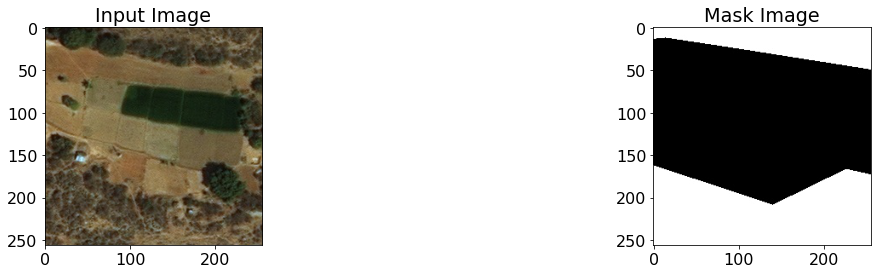

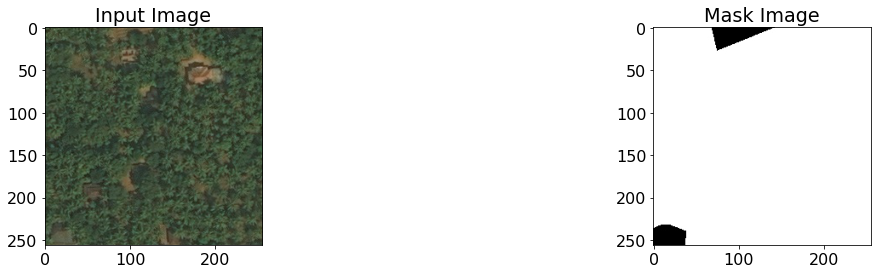

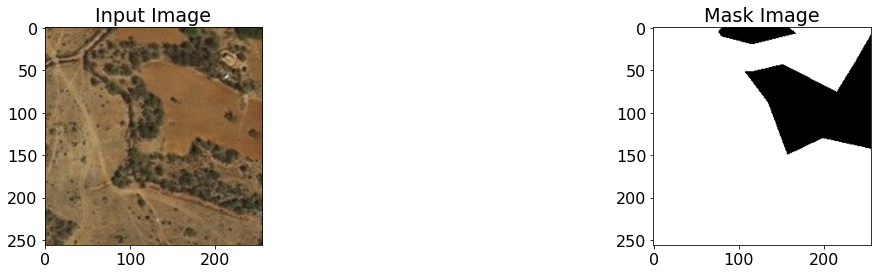

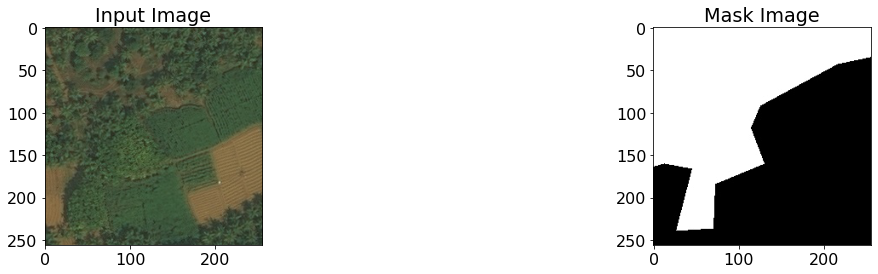

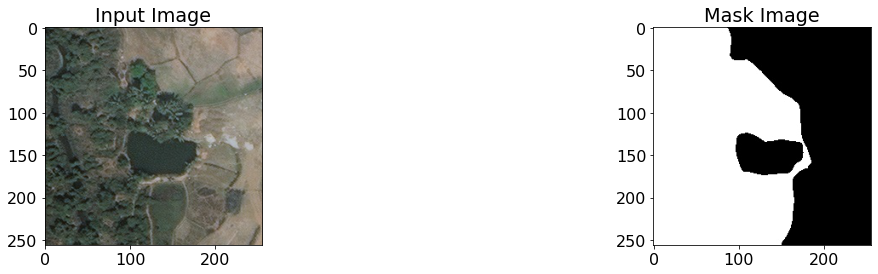

In [6]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

# U-Net: Segmentation Architecture
- It is an encoder-decoder architecture that downsamples an image input using convolutional filters and identifies all the features of the image and then upsamples them by applying transpose convolutions on the downsampled feature maps concatenated with some feature maps from their encoder counterpart
- The original U-Net model did not have padding set as same in its convolutional blocks, therefore in the image it can be seen that the input is downsampled after each convolution operation.
- However, we will set padding as same for our model
- We have also changed the architecture slighlty by adding an additional block of convolutional layer, beginning with 32 filters block contrary to the 64 fitlers block in the original paper
- Since the feature maps in the encoder section will also consider some useful information we concatenate them with the output of the transpose convolution operation while upsampling so that it can use that information to predict the segmentation masks

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

In [7]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    
    

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_plusplus(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="unet_plusplus")
    return model


In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer="he_normal")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_plusplus(input_shape ,name="unet_plusplus"):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name=name)
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust according to your input data shape
model = build_unet_plusplus(input_shape)
model.summary()


Model: "unet_plusplus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [9]:
"""from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    x = MaxPool2D((2, 2))(x)  # Adjusted MaxPool layer
    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)"""
"""    skip_features = Conv2D(num_filters, (1, 1), padding="same")(skip_features)  # 1x1 convolution
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_plusplus(input_shape):
    inputs = Input(input_shape)

    # Use ResNet50 as a pre-trained encoder
    encoder = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    encoder.trainable = False  # Freeze pre-trained weights
    encoder_output = encoder(inputs)

    # Use an intermediate layer for compatibility
    intermediate_layer = encoder.layers[80].output  # Adjust this index based on your needs
    s1 = encoder_block(intermediate_layer, 256)
    s2 = encoder_block(s1, 512)
    s3 = encoder_block(s2, 1024)
    s4 = encoder_block(s3, 2048)

    b1 = conv_block(s4, 4096)

    d1 = decoder_block(b1, s4, 2048)
    d2 = decoder_block(d1, s3, 1024)
    d3 = decoder_block(d2, s2, 512)
    d4 = decoder_block(d3, s1, 256)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="unet_plusplus")
    return model"""

# Test the model with the specified input shape
"""model = build_unet_plusplus((256, 256, 3))
model.summary()
"""


'model = build_unet_plusplus((256, 256, 3))\nmodel.summary()\n'

In [10]:
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = UpSampling2D((2, 2))(input)
    x = concatenate([x, skip_features], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_mobilenet_unet(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    # Use the last few layers from MobileNetV2 as the feature extractor
    backbone_output = base_model.get_layer('block_13_expand_relu').output

    # Decoder
    d1 = decoder_block(backbone_output, base_model.get_layer('block_6_expand_relu').output, 256)
    d2 = decoder_block(d1, base_model.get_layer('block_3_expand_relu').output, 128)
    d3 = decoder_block(d2, base_model.get_layer('block_1_expand_relu').output, 64)
    d4 = decoder_block(d3, base_model.input, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=base_model.input, outputs=outputs, name="mobilenet_unet")
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust according to your input size
model = build_mobilenet_unet(input_shape)"""



'from tensorflow.keras.applications import MobileNetV2\nfrom tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, concatenate, UpSampling2D\nfrom tensorflow.keras.models import Model\n\ndef conv_block(input, num_filters):\n    x = Conv2D(num_filters, 3, padding="same")(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n    \n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef decoder_block(input, skip_features, num_filters):\n    x = UpSampling2D((2, 2))(input)\n    x = concatenate([x, skip_features], axis=-1)\n    x = conv_block(x, num_filters)\n    return x\n\ndef build_mobilenet_unet(input_shape):\n    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=\'imagenet\')\n    base_model.trainable = False\n\n    # Use the last few layers from MobileNetV2 as the feature extractor\n    backbone_output = base_model.get_layer(\'block_13_e

In [11]:
"""from tensorflow.keras.layers import Input,AvgPool2D, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate

def atrous_conv_block(input, num_filters, rate):
    x = Conv2D(num_filters, 3, padding="same", dilation_rate=rate)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", dilation_rate=rate)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block_1(input, num_filters, rates):
    x = input
    skip_connections = []
    for rate in rates:
        x = atrous_conv_block(x, num_filters, rate)
        skip_connections.append(x)

    x = Concatenate()(skip_connections)
    x = Conv2D(num_filters, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block_1(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = atrous_conv_block(x, num_filters, rate=1)  # Use rate=1 for regular convolution
    return x
from tensorflow.keras.applications import ResNet50
def build_deeplab(input_shape):


# ... other functions remain the same ...


    inputs = Input(input_shape)

    # Load ResNet50 as feature extractor:
    base_model = ResNet50(
        weights="imagenet", include_top=False, input_tensor=inputs
    )  # Efficiently load pre-trained model

    # Extract features from the last layer:
    for layer in base_model.layers:
        layer.trainable = False

    # Extract features from the last layer:
    features = base_model.output
    
    inputs = Input(input_shape)
    
    rates = [1, 2, 4]  # Atrous rates for capturing multi-scale information

    b1 = atrous_conv_block(features, 512, rate=1)

# Decoder blocks with skip connections:
    d1 = decoder_block_1(b1, features, 256)  # Note: Using features directly as skip connection
    d2 = decoder_block_1(d1, features, 128)  # Adjust accordingly if skip connections from earlier layers are needed
    d3 = decoder_block_1(d2, features, 64)
    d4 = decoder_block_1(d3, features, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="deeplab")
    return model
"""
# Example usage:

'from tensorflow.keras.layers import Input,AvgPool2D, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate\n\ndef atrous_conv_block(input, num_filters, rate):\n    x = Conv2D(num_filters, 3, padding="same", dilation_rate=rate)(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    x = Conv2D(num_filters, 3, padding="same", dilation_rate=rate)(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef encoder_block_1(input, num_filters, rates):\n    x = input\n    skip_connections = []\n    for rate in rates:\n        x = atrous_conv_block(x, num_filters, rate)\n        skip_connections.append(x)\n\n    x = Concatenate()(skip_connections)\n    x = Conv2D(num_filters, 1, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    p = MaxPool2D((2, 2))(x)\n    return x, p\n\ndef decoder_block_1(input, skip_features, num_filters):\n    x = Conv2DTranspose(num_filters, (2, 2), stri

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate

def linknet_encoder_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def linknet_decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_linknet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    e1 = linknet_encoder_block(inputs, 32)
    p1 = MaxPool2D((2, 2))(e1)
    e2 = linknet_encoder_block(p1, 64)
    p2 = MaxPool2D((2, 2))(e2)
    e3 = linknet_encoder_block(p2, 128)
    p3 = MaxPool2D((2, 2))(e3)
    e4 = linknet_encoder_block(p3, 256)
    p4 = MaxPool2D((2, 2))(e4)

    # Center block
    center = linknet_encoder_block(p4, 512)

    # Decoder
    d4 = linknet_decoder_block(center, e4, 256)
    d3 = linknet_decoder_block(d4, e3, 128)
    d2 = linknet_decoder_block(d3, e2, 64)
    d1 = linknet_decoder_block(d2, e1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="linknet")
    return model


In [13]:
from tensorflow.keras.layers import Average
num_models=2
# Create a list to hold the models
models = []

# Build and append multiple models to the list
for i in range(num_models):
    model = build_unet_plusplus(input_shape,name=f"model_{i}")
    models.append(model)

# Create an input layer for each model
ensemble_inputs = Input(input_shape)
model_inputs = [ensemble_inputs for _ in range(num_models)]

# Get the outputs of each model
ensemble_outputs = [model(input_tensor) for model, input_tensor in zip(models, model_inputs)]

# Average the predictions
average = Average()(ensemble_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_inputs, outputs=average, name="ensemble_unet_plusplus")

# Example usage
# Use the ensemble model with a single input tensor
input_tensor = Input(input_shape)
ensemble_prediction = ensemble_model(input_tensor)

# Create the final model
final_model = Model(inputs=input_tensor, outputs=ensemble_prediction, name="final_ensemble_model")

final_model.summary()





Model: "final_ensemble_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
ensemble_unet_plusplus (Func (None, 256, 256, 1)       62110594  
Total params: 62,110,594
Trainable params: 62,087,042
Non-trainable params: 23,552
_________________________________________________________________


In [14]:
from tensorflow.keras.layers import Average, Input

# Build LinkNet model
linknet_input_shape = (256, 256, 3)  # Adjust according to your input data shape
linknet_model = build_linknet(linknet_input_shape)

# Build UNet++ model
unetplusplus_input_shape = (256, 256, 3)  # Adjust according to your input data shape
unetplusplus_model = build_unet_plusplus(unetplusplus_input_shape)

# Create an input layer for each model
ensemble_inputs_linknet = Input(linknet_input_shape)
ensemble_inputs_unetplusplus = Input(unetplusplus_input_shape)

# Get the outputs of each model
linknet_output = linknet_model(ensemble_inputs_linknet)
unetplusplus_output = unetplusplus_model(ensemble_inputs_unetplusplus)

# Average the predictions
average = Average()([linknet_output, unetplusplus_output])

# Create the ensemble model
ensemble_model = Model(inputs=[ensemble_inputs_linknet, ensemble_inputs_unetplusplus], outputs=average, name="ensemble_model")

ensemble_model.summary()


Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
linknet (Functional)            (None, 256, 256, 1)  7771873     input_8[0][0]                    
__________________________________________________________________________________________________
unet_plusplus (Functional)      (None, 256, 256, 1)  31055297    input_9[0][0]                    
_____________________________________________________________________________________

In [15]:
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def linknet_encoder_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def linknet_decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_linknet_mobilenet(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(input_shape)

    # Encoder
    e1 = linknet_encoder_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(e1)
    e2 = linknet_encoder_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(e2)
    e3 = linknet_encoder_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(e3)
    e4 = linknet_encoder_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(e4)

    # Center block
    center = linknet_encoder_block(p4, 512)

    # Decoder
    d4 = linknet_decoder_block(center, e4, 256)
    d3 = linknet_decoder_block(d4, e3, 128)
    d2 = linknet_decoder_block(d3, e2, 64)
    d1 = linknet_decoder_block(d2, e1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs=inputs, outputs=outputs, name="linknet_mobilenet")
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust according to your input size
model = build_linknet_mobilenet(input_shape)"""







'from tensorflow.keras.applications import MobileNetV2\nfrom tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate\nfrom tensorflow.keras.models import Model\n\ndef linknet_encoder_block(input, num_filters):\n    x = Conv2D(num_filters, 3, padding="same")(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef linknet_decoder_block(input, skip_features, num_filters):\n    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)\n    x = Concatenate()([x, skip_features])\n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef build_linknet_mobilenet(input_shap

In [16]:
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.models import Model

def conv_block_mobile(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", strides=1)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
from tensorflow.keras.applications import MobileNetV2

def encoder_block_mobile(input, num_filters):
    x = conv_block_mobile(input, num_filters)
    mobilenet_model = MobileNetV2(input_shape=(None, None, 3), include_top=False)
    mobilenet_output = mobilenet_model(x)
    p = MaxPool2D((2, 2))(mobilenet_output)
    return mobilenet_output, p

def decoder_block_mobile(input, skip_features, num_filters):
    x = UpSampling2D((2, 2))(input)
    x = Concatenate()([x, skip_features])
    x = conv_block_mobile(x, num_filters)
    return x

def build_unet_plusplus_mobile(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block_mobile(inputs, 32)
    s2, p2 = encoder_block_mobile(p1, 64)
    s3, p3 = encoder_block_mobile(p2, 128)
    s4, p4 = encoder_block_mobile(p3, 256)

    b1 = conv_block_mobile(p4, 512)

    d1 = decoder_block_mobile(b1, s4, 256)
    d2 = decoder_block_mobile(d1, s3, 128)
    d3 = decoder_block_mobile(d2, s2, 64)
    d4 = decoder_block_mobile(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="unet_plusplus_mobile")
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust the input shape as needed
model = build_unet_plusplus_mobile(input_shape)
model.summary()"""


'from tensorflow.keras.applications import MobileNetV2\nfrom tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, UpSampling2D\nfrom tensorflow.keras.models import Model\n\ndef conv_block_mobile(input, num_filters):\n    x = Conv2D(num_filters, 3, padding="same", strides=1)(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n    return x\nfrom tensorflow.keras.applications import MobileNetV2\n\ndef encoder_block_mobile(input, num_filters):\n    x = conv_block_mobile(input, num_filters)\n    mobilenet_model = MobileNetV2(input_shape=(None, None, 3), include_top=False)\n    mobilenet_output = mobilenet_model(x)\n    p = MaxPool2D((2, 2))(mobilenet_output)\n    return mobilenet_output, p\n\ndef decoder_block_mobile(input, skip_features, num_filters):\n    x = UpSampling2D((2, 2))(input)\n    x = Concatenate()([x, skip_features])\n    x = conv_block_mobile(x, num_filters)\n    return x\n\ndef build_unet_p

In [17]:
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = UpSampling2D((2, 2))(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_mobilenet_unet_skip(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    # Use the last few layers from MobileNetV2 as the feature extractor
    backbone_output = base_model.get_layer('block_12_expand_relu').output

    # Encoder
    s1, p1 = encoder_block(backbone_output, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder with skip connections
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=base_model.input, outputs=outputs, name="mobilenet_unet_skip")
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust according to your input size
model = build_mobilenet_unet_skip(input_shape)
"""

'from tensorflow.keras.applications import MobileNetV2\nfrom tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate\nfrom tensorflow.keras.models import Model\n\ndef conv_block(input, num_filters):\n    x = Conv2D(num_filters, 3, padding="same")(input)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n    \n    x = Conv2D(num_filters, 3, padding="same")(x)\n    x = BatchNormalization()(x)\n    x = Activation("relu")(x)\n\n    return x\n\ndef encoder_block(input, num_filters):\n    x = conv_block(input, num_filters)\n    p = MaxPooling2D((2, 2))(x)\n    return x, p\n\ndef decoder_block(input, skip_features, num_filters):\n    x = UpSampling2D((2, 2))(input)\n    x = Concatenate()([x, skip_features])\n    x = conv_block(x, num_filters)\n    return x\n\ndef build_mobilenet_unet_skip(input_shape):\n    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=\'imagenet\')\n    base_model.trainable = False\n

In [18]:
# -*- coding: utf-8 -*-

""" Deeplabv3+ model for Keras.
This model is based on TF repo:
https://github.com/tensorflow/models/tree/master/research/deeplab
On Pascal VOC, original model gets to 84.56% mIOU

MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras

# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""



  


' Deeplabv3+ model for Keras.\nThis model is based on TF repo:\nhttps://github.com/tensorflow/models/tree/master/research/deeplab\nOn Pascal VOC, original model gets to 84.56% mIOU\n\nMobileNetv2 backbone is based on this repo:\nhttps://github.com/JonathanCMitchell/mobilenet_v2_keras\n\n# Reference\n- [Encoder-Decoder with Atrous Separable Convolution\n    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)\n- [Xception: Deep Learning with Depthwise Separable Convolutions]\n    (https://arxiv.org/abs/1610.02357)\n- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for\n    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)\n'

In [19]:
from tensorflow.keras.layers import Average, Input

# Build LinkNet model
input_shape = (256, 256, 3)  # Adjust according to your input data shape
linknet_model = build_linknet(input_shape)
unetplusplus_model = build_unet_plusplus(input_shape)

# Create an input layer for the ensemble
ensemble_inputs = Input(input_shape)

# Get the outputs of each model
linknet_output = linknet_model(ensemble_inputs)
unetplusplus_output = unetplusplus_model(ensemble_inputs)

# Average the predictions
average = Average()([linknet_output, unetplusplus_output])

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_inputs, outputs=average, name="ensemble_model")

ensemble_model.summary()


Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
linknet (Functional)            (None, 256, 256, 1)  7771873     input_12[0][0]                   
__________________________________________________________________________________________________
unet_plusplus (Functional)      (None, 256, 256, 1)  31055297    input_12[0][0]                   
__________________________________________________________________________________________________
average_2 (Average)             (None, 256, 256, 1)  0           linknet[0][0]                    
                                                                 unet_plusplus[0][0] 

# Custom Metrics
- Most important metric in image segmentation tasks is always the Intersection over Union (IoU)
- The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. 

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig2.png">

In [20]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# Model Training
- Compile the model and set the remaining hyperparameters
- Add the required callbacks
- Feel free to monitor the iou_metric for early stopping, as for this kernel I have set the binary_crossentropy (default val loss) as the monitoring criteria
- We can also add iou_loss for the optimization or take a weighted average of both binary crossentropy and the iou to optimize the parameters of our model

In [21]:
input_shape = (img_dim, img_dim, 3)

model =build_unet_plusplus(input_shape)

ensemble_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 5e-4), loss = ['binary_crossentropy'], metrics=['accuracy'])
ensemble_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
linknet (Functional)            (None, 256, 256, 1)  7771873     input_12[0][0]                   
__________________________________________________________________________________________________
unet_plusplus (Functional)      (None, 256, 256, 1)  31055297    input_12[0][0]                   
__________________________________________________________________________________________________
average_2 (Average)             (None, 256, 256, 1)  0           linknet[0][0]                    
                                                                 unet_plusplus[0][0] 

In [22]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

## Let's train the Model ! 

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [23]:
history = ensemble_model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=35, callbacks=[earlystop, checkpoint])

Epoch 1/35
135/135 [==============================] - 191s 1s/step - loss: 0.5510 - accuracy: 0.7195 - val_loss: 6.7984 - val_accuracy: 0.3762

Epoch 00001: val_accuracy improved from -inf to 0.37620, saving model to unet.h5
Epoch 2/35
135/135 [==============================] - 172s 1s/step - loss: 0.4928 - accuracy: 0.7690 - val_loss: 0.8699 - val_accuracy: 0.5466

Epoch 00002: val_accuracy improved from 0.37620 to 0.54657, saving model to unet.h5
Epoch 3/35
135/135 [==============================] - 164s 1s/step - loss: 0.4661 - accuracy: 0.7807 - val_loss: 0.6662 - val_accuracy: 0.7116

Epoch 00003: val_accuracy improved from 0.54657 to 0.71162, saving model to unet.h5
Epoch 4/35
135/135 [==============================] - 164s 1s/step - loss: 0.4514 - accuracy: 0.7926 - val_loss: 0.5937 - val_accuracy: 0.7194

Epoch 00004: val_accuracy improved from 0.71162 to 0.71943, saving model to unet.h5
Epoch 5/35
135/135 [==============================] - 164s 1s/step - loss: 0.4566 - accurac

# Inferencing
- Learning Curves
- Ground Truth Masks vs Predicted Masks

In [24]:
import seaborn as sns
sns.set_style('dark')

## Learning Curve

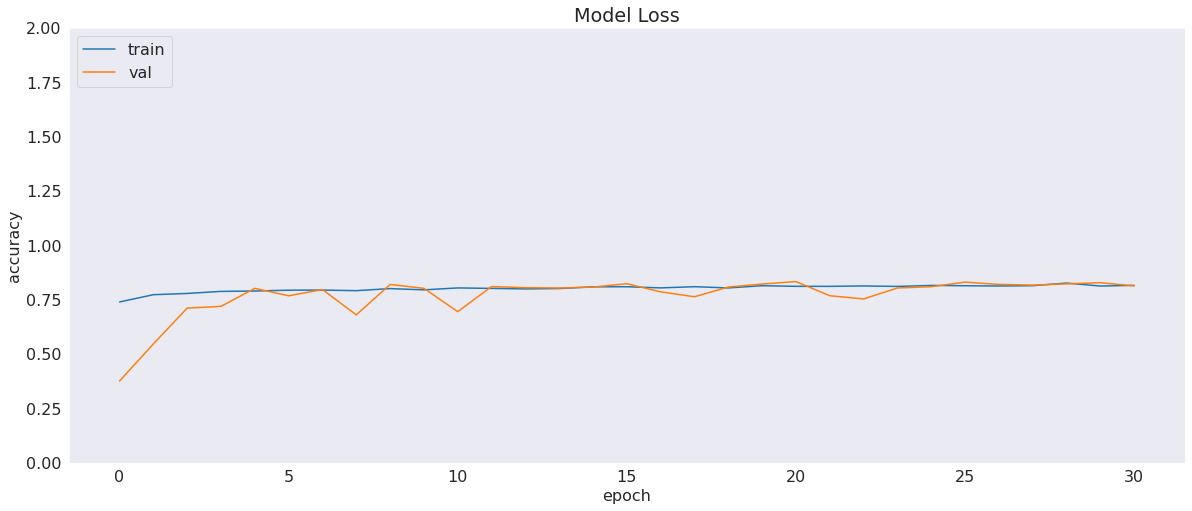

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

## Ground Truth Masks vs Predicted Masks

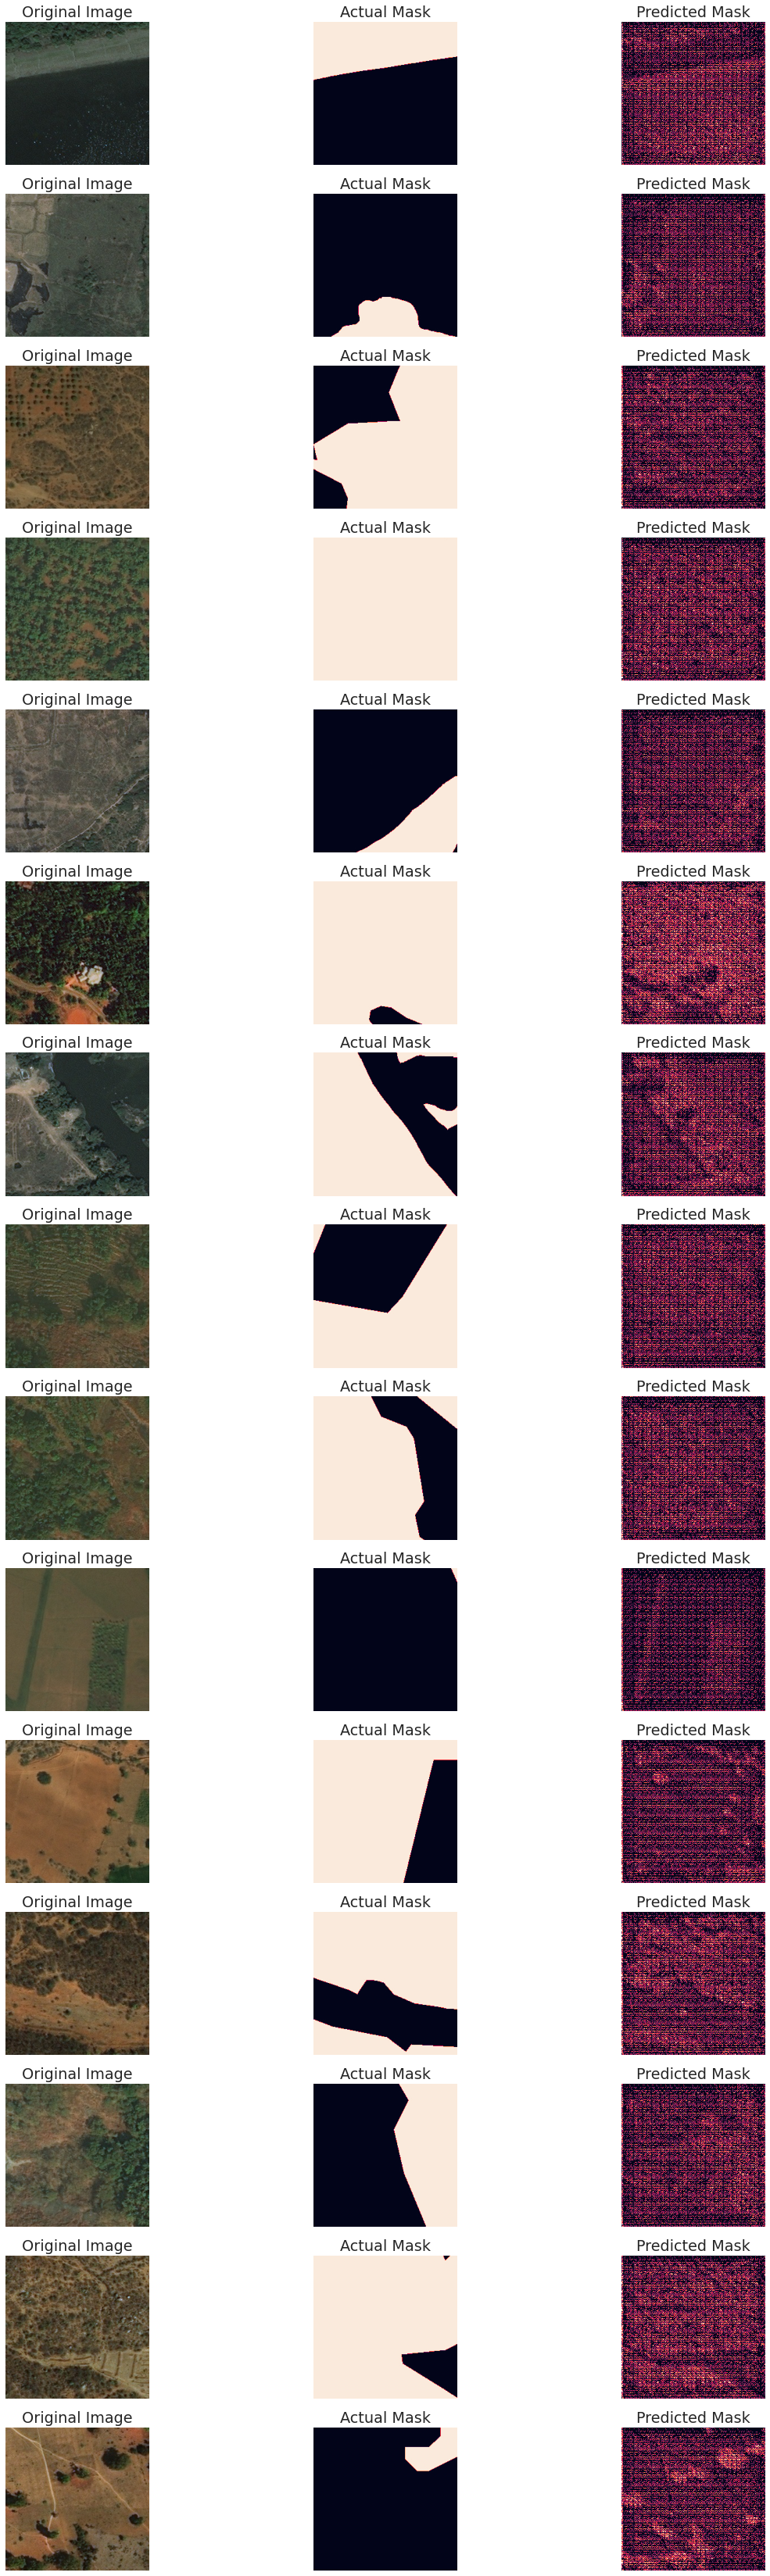

In [27]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

# Conclusion
- In some cases the segmented masks do not match with the ground truth mask. The reason behind this is that some of the images were not properly labelled during the data preparation.
- Therefore our model is able to identify certain features that help us segment the forest areas which are not labelled in ground truth images.
- However, the overall performance of our model can be improved by using different metrics relevant to image segmentation